# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way range data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging range data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
goldstone_start = goldstone_end - 5*u.hour
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
fit_offsets = np.arange(0, (goldstone_end - goldstone_start)/(1*u.s), sampling_interval)
fit_epochs = goldstone_start + (fit_offsets << u.s)
print("Start and end epochs:", goldstone_start, fit_epochs[-1], "[", fit_epochs.size, "]")

Start and end epochs: 1998-01-23 01:14:55.600 1998-01-23 06:14:55.600 [ 301 ]


In [3]:
near_goldstone_start_rv = Ephem.from_horizons("NEAR", goldstone_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(goldstone_start)
describe_state(near_goldstone_start_rv, dss25, goldstone_start)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_start_rv[0], near_goldstone_start_rv[1], goldstone_start)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 01:14:55.600
Geocentric distance: 170567.65621007947 km speed: 7.183503343208053 km / s
From Goldstone-25 : range  166458.07986262924 km , range rate  -7.465920108908227 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9732496436772 deg
Eccentricity: 1.8134996008951505
Semilatus rectum: 19440.235051668238 km
Semimajor axix: -8493.707667805164 km
Periapse radius: 6909.62779787958 km , altitude: 531.4911978795799 km


In [4]:
near_goldstone_ephem = near_goldstone_orbit.to_ephem(EpochsArray(fit_epochs))
describe_trajectory(near_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 166010.12785733113 km 31573.915329633066 km
Start and end radial speeds: -7.465920108908282 km / s -7.684678614009732 km / s
Closest: 31573.915329633066 km speed 8.258629481934712 km / s  at  1998-01-23 06:14:55.600
Deflection: 1.4531854375528002 deg


In [5]:
ref_data = []
sim_meas_data = []
for e in fit_epochs:
    ref_r, ref_rr = dss25.range_and_rate(near_goldstone_ephem.rv(e), e)
    ref_data.append(ref_r)
    sim_meas_data.append([ref_r - ref_rr*ref_r/const.c])

print(ref_data)
print(sim_meas_data)

[<Quantity 166458.07986259 km>, <Quantity 166010.12785733 km>, <Quantity 165562.18234988 km>, <Quantity 165114.2434836 km>, <Quantity 164666.31139955 km>, <Quantity 164218.38623645 km>, <Quantity 163770.46813069 km>, <Quantity 163322.5572163 km>, <Quantity 162874.6536249 km>, <Quantity 162426.75748572 km>, <Quantity 161978.86892557 km>, <Quantity 161530.9880688 km>, <Quantity 161083.1150373 km>, <Quantity 160635.24995046 km>, <Quantity 160187.39292517 km>, <Quantity 159739.54407577 km>, <Quantity 159291.70351407 km>, <Quantity 158843.87134929 km>, <Quantity 158396.04768804 km>, <Quantity 157948.23263432 km>, <Quantity 157500.42628949 km>, <Quantity 157052.62875225 km>, <Quantity 156604.84011859 km>, <Quantity 156157.06048181 km>, <Quantity 155709.28993245 km>, <Quantity 155261.52855832 km>, <Quantity 154813.77644443 km>, <Quantity 154366.033673 km>, <Quantity 153918.30032339 km>, <Quantity 153470.57647214 km>, <Quantity 153022.8621929 km>, <Quantity 152575.15755642 km>, <Quantity 15212

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_goldstone_orbit, [dss25], debug=True)

Range constraints:
a: -8408770.59112711 -8578644.744483216
ecc: 1.7953646048861989 1.8316345969041021
inc: 1.865643823256362 1.903333597463561


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_range_data(fit_epochs, sim_meas_data)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

{'a': -8493707.667805163, 'ecc': 1.8134996008951505, 'inc': 1.8844887103599615, 'nu': -2.081249407419048, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951505, 'inc': 1.8844887103599615, 'nu': -2.081249407419048, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951505, 'inc': 1.8844887103599615, 'nu': -2.081249407419048, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.666539501, 'ecc': 1.8134996008951505, 'inc': 1.8844887103599615, 'nu': -2.081249407419048, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.813499601165383, 'inc': 1.8844887103599615, 'nu': -2.081249407419048, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ecc': 1.8134996008951505, 'inc': 1.8844887106407722, 'nu': -2.081249407419048, 'raan': 1.5400636799017355, 'argp': 2.5332017234211355}
{'a': -8493707.667805163, 'ec

In [8]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [9]:
sim_goldstone_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(sim_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32462.898584991835 km 14331.262131864265 km
Start and end radial speeds: -7.679327351360508 km / s -6.9349828835615295 km / s
Closest: 14331.262131864265 km speed 9.427466774696317 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.303130653414349 deg


In [10]:
# also extend the reference trajectory
near_goldstone_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(ssn_epochs))

In [11]:
altair_residuals = []
millstone_residuals = []

for e in ssn_epochs:
    ref_rv = sim_goldstone_ephem.rv(e)
    sim_rv = near_goldstone_extended_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_residuals.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_residuals.append((meas_r - ref_r).to_value(u.m))

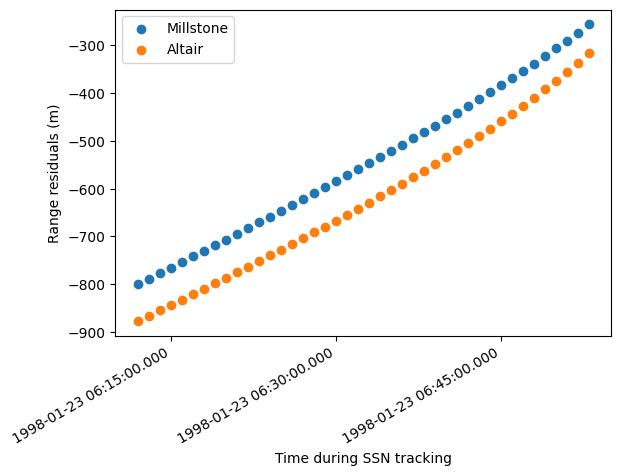

In [12]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Time during SSN tracking')
    plt.ylabel('Range residuals (m)')
    plt.scatter(ssn_epochs, millstone_residuals, label="Millstone")
    plt.scatter(ssn_epochs, altair_residuals, label="Altair")
    plt.legend(loc=0)
    plt.gcf().autofmt_xdate()

In [13]:
from czml3.widget import CZMLWidget
from poliastro.czml.extract_czml import CZMLExtractor

czml = CZMLExtractor(ssn_epochs[0], ssn_epochs[-1], ssn_epochs.size)
#dss25.add_to_czml(czml, "#333")
#dss34.add_to_czml(czml, "#333")
ssrAltair.add_to_czml(czml, "#111")
ssrMillstone.add_to_czml(czml, "#111")
czml.add_orbit(near_goldstone_orbit)
czml.add_orbit(fitter.orbit)

CZMLWidget(czml.get_document())

CZMLWidget(document=Document(_values=[Preamble(id='document', version='1.0', name='document_packet', description=None, clock=IntervalValue(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>, _value=Clock(currentTime=datetime.datetime(1998, 1, 23, 6, 12, tzinfo=datetime.timezone.utc), multiplier=60, range=<ClockRanges.LOOP_STOP: 3>, step=<ClockSteps.SYSTEM_CLOCK_MULTIPLIER: 2>))), Packet(id='custom_properties', delete=None, name=None, parent=None, description=None, availability=None, properties={'custom_attractor': True, 'ellipsoid': [{'array': (6378136.6, 6378136.6, 6356751.9)}], 'map_url': ('https://upload.wikimedia.org/wikipedia/commons/c/c4/Earthmap1000x500compac.jpg',), 'scene3D': True}, position=None, orientation=None, viewFrom=None, billboard=None, box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=None, model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS0', delete=None, name=None, parent=None, description='Altair', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[-6143471.429543289, 1364300.4818256705, 1034339.9636133286], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<LabelStyles.FILL: 1>, scale=None, showBackground=None, backgroundColor=None, fillColor=Color(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, rgba='#111', rgbaf=None), outlineColor=None, outlineWidth=1.0, pixelOffset=None), model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS1', delete=None, name=None, parent=None, description='Millstone', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T06:12:00.000>, _end=<Time object: scale='tdb' format='isot' value=1998-01-23T06:53:00.000>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[1492298.8700490487, -4457675.543085808, 4296323.883602885], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<Labe

See [screenshot](near_sim_ssn_altbyrange_trajectory.png)